In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt



# Creating 3D model

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# PCA using SVD decomposition

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

In [8]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [9]:
X[:5]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496]])

# Using Scikit_learn

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [12]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [13]:
pca.components_.T

array([[-0.93636116,  0.34027485],
       [-0.29854881, -0.90119108],
       [-0.18465208, -0.2684542 ]])

In [14]:
pca.components_.T[:,0]

array([-0.93636116, -0.29854881, -0.18465208])

# Explained Vaqrience Ratio

In [15]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [16]:
pca.explained_variance_

array([0.77830975, 0.1351726 ])

# choosing right number of Dimension

In [17]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [18]:
from sklearn.model_selection import train_test_split
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +1

In [20]:
d

154

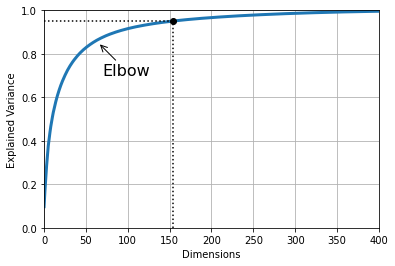

In [21]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [22]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [23]:
pca.n_components_

154

In [24]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

In [25]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [26]:

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

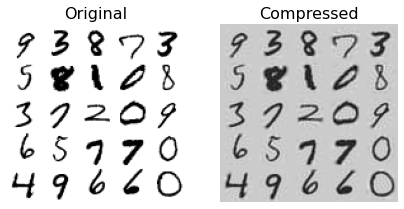

In [27]:

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


In [28]:
rnd_pca = PCA(n_components=154, svd_solver= 'randomized')
X_reduced = rnd_pca.fit_transform(X_train)

In [29]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.fit(X_train)    

In [30]:
filename = 'my_mnist.data'
m,n=X_train.shape
X_mm = np.memmap(filename, dtype='float32',mode ='write',shape= (m,n))
X_mm[:]=X_train

In [31]:
del X_mm

In [32]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [33]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [34]:

import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 5.8 seconds
    Inc PCA: 19.3 seconds
    Rnd PCA: 2.4 seconds
n_components = 10
    PCA: 6.1 seconds
    Inc PCA: 23.5 seconds
    Rnd PCA: 3.0 seconds
n_components = 154
    PCA: 7.0 seconds
    Inc PCA: 31.0 seconds
    Rnd PCA: 4.9 seconds


# Kernel PCA

In [39]:
from sklearn.datasets import make_swiss_roll

In [40]:
X,t = make_swiss_roll(n_samples = 1000, noise = 0.2 , random_state = 42)

In [41]:
from sklearn.decomposition import KernelPCA

In [42]:
rbf_pca = KernelPCA(n_components= 2, kernel= 'rbf', gamma = 0.04)
X_reduced= rbf_pca.fit_transform(X)

In [44]:
X[0]

array([-3.29677117,  4.26198454,  7.69787682])

In [45]:
t

array([ 8.24234644, 13.67266022, 11.61126935, 10.35461227,  6.18283002,
        6.1826027 ,  5.25981413, 12.87590683, 10.37776449, 11.38581581,
        4.90639327, 13.85357398, 12.55797604,  6.71363795,  6.42604892,
        6.44093576,  7.57980457,  9.65810183,  8.78337487,  7.45715896,
       10.47896666,  6.02708764,  7.46578743,  8.16526801,  9.01074732,
       12.11249808,  6.59427004,  9.55893438, 10.29576475,  5.15017381,
       10.43836431,  6.31954098,  5.3254858 , 13.65542448, 13.81325648,
       12.33135449,  7.58330612,  5.63292697, 11.16113333,  8.8607285 ,
        5.86257225,  9.37932141,  5.03649316, 13.28253187,  7.15133285,
       10.9565144 ,  7.65019666,  9.6139146 ,  9.86501197,  6.45460118,
       13.85050881, 12.01784373, 13.5669579 , 13.14593807, 10.34746352,
       13.40084895,  5.54641116,  6.55948394,  5.13864614,  7.77855511,
        8.37558613,  7.26979335, 12.52305599,  8.07470987,  7.36013436,
        9.82717906,  6.04056851, 12.2729174 ,  5.41501224, 14.01

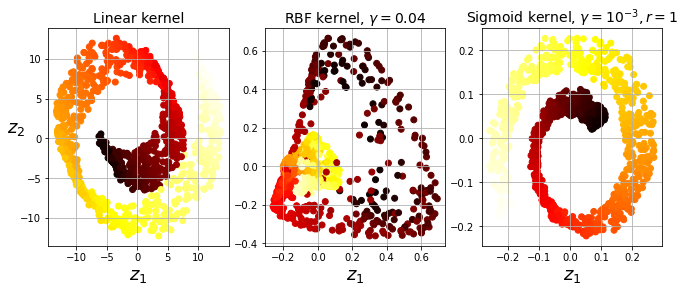

In [46]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()